In [1]:
import pandas as pd
##Pre-processing
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

#Model Evaluation
from sklearn import metrics
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay, roc_auc_score,precision_score,recall_score,f1_score
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from scipy.sparse import csr_matrix, hstack
from scipy.stats import ks_2samp


#Model Building
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import StackingCVClassifier
from sklearn import model_selection
import xgboost as xgb

#All Purpose
import numpy as np
import pickle
import seaborn as sns
import warnings
import joblib
import matplotlib.pyplot as plt

%matplotlib inline
warnings.filterwarnings("ignore")

E:\Softwares\Anaconda\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Reading Train_Test Split  Data

 - As part of gender prediction data was encoded and numerical columns were scaled to same range of values.
 - Data was also split into train and test which can be used here directly.

In [2]:
#Reading Saved Training Data
path = 'E:\Shobhit\MSDS\Capstone\Y1_Capstone\MLModels\Train_Test_Data\Scenario 1'
df_s1_data_train = pd.read_csv(f'{path}\\df_s1_data_train.csv')

In [3]:
df_s1_data_train.shape

(17391, 1034)

In [4]:
df_s1_data_train.drop('train_test_flag',axis=1,inplace=True)
df_s1_data_train.shape

(17391, 1033)

### Why Classification Model Was Chosen for Age Prediction

- Age prediction is subjective and depends on various factors such as genetics, lifestyle, health, etc. Therefore, it is hard to define a precise age for a person based on their appearance.
- Age prediction is often used for applications that do not require exact age, but rather a rough estimate or a range. For example, age-based marketing, face verification, demographic analysis, etc.
- Classification can reduce the error and variance of the prediction by grouping similar ages into bins or categories. For example, instead of predicting 23 or 24 years old, we can predict 20-25 years old as a class.


In [15]:
def create_age_bins(age):
    if 0<= age <= 24:
        return 0 #for 0-24
    elif 25<= age <= 32:
        return 1 #for 25-32
    elif age > 32:
        return 2 #for 32+
        

In [16]:
#Separating target variables with features for training data
#For Male we would be denoting by 1 and for female by 0
X_train_s1 = df_s1_data_train.drop(columns= ['gender','age','device_id'],axis=1)
Y_train_s1_age = df_s1_data_train['age'].apply(lambda x:create_age_bins(x))
Y_train_s1_age = df_s1_data_train['gender'].apply(lambda gender : 1 if gender == 'M' else 0)
Y_train_s1_age
print(X_train_s1.shape)
print(Y_train_s1_age.shape)
print(Y_train_s1_age.shape)

(17391, 1030)
(17391,)
(17391,)


In [17]:
#Reading Saved Test Data
path = 'E:\Shobhit\MSDS\Capstone\Y1_Capstone\MLModels\Train_Test_Data\Scenario 1'
df_s1_data_test = pd.read_csv(f'{path}\\df_s1_data_test.csv')
df_s1_data_test.shape

(5791, 1034)

In [18]:
df_s1_data_test.drop('train_test_flag',axis=1,inplace=True)
df_s1_data_test.shape

(5791, 1033)

In [19]:
#Separating target variables with features for test data
X_test_s1 = df_s1_data_test.drop(columns= ['gender','age','device_id'],axis=1)
Y_test_s1_age = df_s1_data_test['age'].apply(lambda x:create_age_bins(x))
print(X_test_s1.shape)
print(Y_test_s1_age.shape)


(5791, 1030)
(5791,)


### Creating Helper Functions for Model Evaluation

In [53]:
#Below dict will contain all the evaluation metrics for each model which would be later used for comparison
model_evaluation_dict_age = {
    'Model_Name':[],
    'Training_Accuracy':[],
    'Testing_Accuracy':[],
    'Precision_Training':[],
    'Precision_Testing':[],
    'Recall_Training':[],
    'Recall_Testing':[],
    'F1Score_Training':[],
    'F1Score_Testing':[],
    'Multiclass_log_loss_Training':[],
    'Multiclass_log_loss_Testing':[],
}

In [54]:
def multiclass_log_loss(y_true, y_pred):
    eps = 1e-15
    y_pred = np.clip(y_pred, eps, 1 - eps)
    N = len(y_true)
    loss = -np.sum(y_true * np.log(y_pred)) / N
    return loss

In [55]:
def evaluate_model(model, data, y_true, isTraining=True):
    label = 'Training' if isTraining else 'Testing'
    
    print(f'Evaluating {label} performance')
    
    #Prediciting target variable on training data
    y_pred = model.predict(data)
    #Calculating Accuracy
    accuracy = metrics.balanced_accuracy_score(y_true, y_pred)
    print(f'Accuracy:{accuracy}')
    
    #Calculating Precision and Recall Score
    precision = precision_score(y_true, y_pred, average="weighted")
    recall = recall_score(y_true, y_pred, average="weighted")
    print(f'Precision:{precision}')
    print(f'Recall:{recall}')
    
    #Calculating F1-Score
    f1 = f1_score(y_true, y_pred,average='weighted')
    print(f'F1Score:{f1}')
    
    #Plotting Confusion Matrix
    cm = confusion_matrix(y_true, y_pred, labels=[0,1,2])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=[0,1,2])
    disp.plot()
        
    #Evaluating log loss
    log_loss = multiclass_log_loss(y_true, y_pred) 
    
    #Adding above generated evaluation metrics to the model_evaluation_dict_age
    model_evaluation_dict_age[f'{label}_Accuracy'].append(accuracy)
    model_evaluation_dict_age[f'Precision_{label}'].append(precision)
    model_evaluation_dict_age[f'Recall_{label}'].append(recall)
    model_evaluation_dict_age[f'F1Score_{label}'].append(f1)
    model_evaluation_dict_age[f'Multiclass_log_loss_{label}'].append(log_loss)


### Logistic Regression Model for Predicting `Age` for Scenario 1

- Logistic regression model will be used as a benchmark to compare the other Machine learning models.

In [56]:
Y_train_s1_age.value_counts()

1    7086
2    6772
0    3533
Name: age, dtype: int64

In [57]:
#As it is an unbalanced data set compute the appropiate class weight to be assigned to the model
weights = class_weight.compute_class_weight(class_weight='balanced',classes=np.unique(Y_train_s1_age),y = Y_train_s1_age)
print(weights)
class_weights = dict(zip(np.unique(Y_train_s1_age), weights))
print(class_weights)

[1.64081517 0.81809201 0.85602481]
{0: 1.64081517124257, 1: 0.8180920124188541, 2: 0.8560248080330773}


In [44]:
#Declaring the Logistic Regression Model and training the model on the train data
lr_model = LogisticRegression(class_weight = class_weights,random_state=100, max_iter=1500)
lr_model.fit(X_train_s1, Y_train_s1_age)

LogisticRegression(class_weight={0: 1.64081517124257, 1: 0.8180920124188541,
                                 2: 0.8560248080330773},
                   max_iter=1500, random_state=100)

In [48]:
# Saving the Logistic Regression Model as a pickle in a file
path = 'E:\Shobhit\MSDS\Capstone\Y1_Capstone\MLModels\Age Prediction'
filename = f'{path}\\Logistic_Regression_Age_Scenario1.pkl'
pickle.dump(lr_model, open(filename, 'wb'))

In [213]:
# Reading saved Logistic regression model
# path = 'E:\\Shobhit\\MSDS\\Capstone\\Y1_Capstone\\MLModels'
# filename = f'{path}\\Logistic_Regression_Age_Scenario1.pkl'
# lr_model = pickle.load(open(filename, 'rb'))
# print(lr_model)

LogisticRegression(class_weight={0: 1.4453956117021276, 1: 0.7644395604395604},
                   max_iter=1500, random_state=100)


#### Evaluating the Logistic Regression classifier on Training Data Set

Evaluating Training performance
Accuracy:0.4854164531592122
Precision:0.4965448389273585
Recall:0.4704157322753148
F1Score:0.4709104407530134


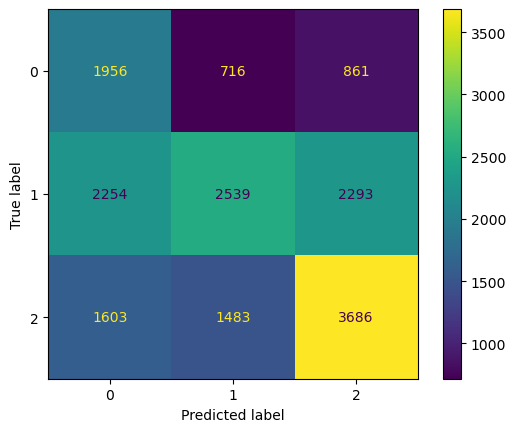

In [58]:
model_evaluation_dict_age['Model_Name'].append('Logistic_Regression')
evaluate_model(lr_model, X_train_s1, Y_train_s1_age)

#### Evaluating the Logistic Regression classifier on Test Data Set

Evaluating Testing performance
Accuracy:0.430699357693958
Precision:0.44077343170206945
Recall:0.4194439647729235
F1Score:0.42054007306029817


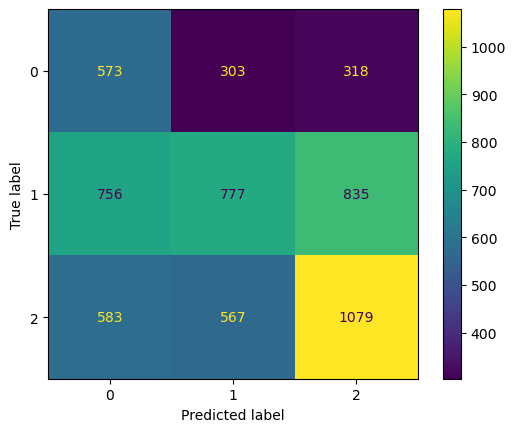

In [59]:
evaluate_model(lr_model, X_test_s1, Y_test_s1_age, False)

### XGBoost Model for Predicting `Age` for Scenario 1

In [60]:
#Training XGBoost Model on train data
xgclf = xgb.XGBClassifier(random_state=100,n_jobs=-1)
xgclf.fit(X_train_s1, Y_train_s1_age)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=-1, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [75]:
# Saving the XGBoost Model as a pickle in a file
path = 'E:\Shobhit\MSDS\Capstone\Y1_Capstone\MLModels\Age Prediction'
filename = f'{path}\\XGBoost_Age_Scenario1.pkl'
pickle.dump(xgclf, open(filename, 'wb'))

In [221]:
# Reading saved XGBoost model
# path = 'E:\\Shobhit\\MSDS\\Capstone\\Y1_Capstone\\MLModels'
# filename = f'{path}\\XGBoost_Age_Scenario1.pkl'
# xgclf = pickle.load(open(filename, 'rb'))
# print(xgclf)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=100, ...)


#### Evaluating the XGBoost classifier on Training Data Set

Evaluating Training performance
Accuracy:0.5289388410532837
Precision:0.6134263619909293
Recall:0.5921453625438445
F1Score:0.5695164706698165


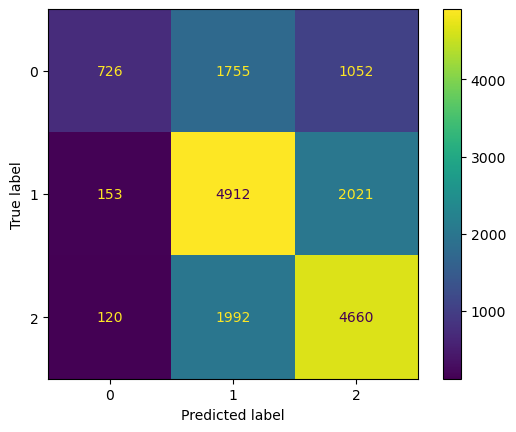

In [61]:
model_evaluation_dict_age['Model_Name'].append('XGBoost_Basic')
evaluate_model(xgclf, X_train_s1, Y_train_s1_age)

#### Evaluating the XGBoost classifier on Test Data Set

Evaluating Testing performance
Accuracy:0.3953359442050584
Precision:0.44813701859301436
Recall:0.45208081505784836
F1Score:0.4257636078709659


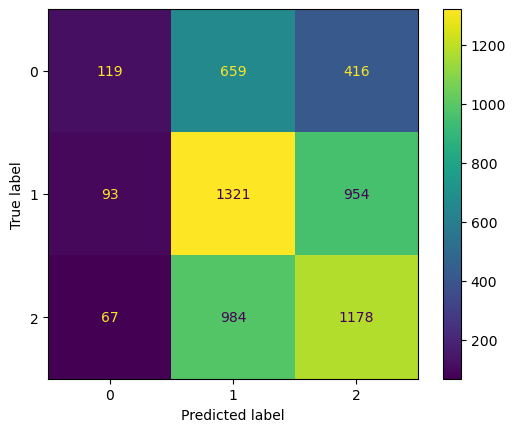

In [62]:
evaluate_model(xgclf, X_test_s1, Y_test_s1_age, False)

### HyperParemter Tuning XGBoost Model for Predicting `Age` for Scenario 1

In [63]:
#StratifiedKFold is used as we want the folds to be created to have the same proportion of class lables as in the data.
cross_validation = StratifiedKFold(n_splits=5,shuffle=True,random_state=42)

In [65]:
#Creating parameter grid
param_grid = {

    'min_child_weight': [1, 5, 10],

    'gamma': [0.5, 1, 1.5, 2, 5],

    'subsample': [0.6, 0.8, 1.0],

    'colsample_by_tree': [0.6, 0.8, 1.0],

    'max_depth': [3, 4, 5],

    'n_estimators': range(60, 360, 40),

    'learning_rate': [0.1, 0.01, 0.05],

 }

In [67]:
#Training XGBoost Model
xgb_model = xgb.XGBClassifier()
clf_xgb_grid = RandomizedSearchCV(xgb_model,
                              param_grid,
                               cv=cross_validation,
                               verbose=4,
                               n_jobs=-1,
                               random_state = 100,
                               error_score="raise")
clf_xgb_grid.fit(X_train_s1, Y_train_s1_age)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[17:50:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "colsample_by_tree" } are not used.



RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   error_score='raise',
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_...
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           predictor=None, random_state=None, ...),
                   n_jobs=-1,
                   param_distributions={'colsample_by_tree': [0.6, 0.8, 1.0],
                                        'gamma': [0.5, 1, 1.5, 2, 5],
                                        'learning_rate': [0.1, 0.01, 0.05],
                                        'max_depth': [3, 4, 5],
                                        'min_child_weight': [1, 5, 10],
                                        'n_estimators': range(60, 360, 40),
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=100, verbose=4)

In [68]:
print(clf_xgb_grid.best_params_)
print(clf_xgb_grid.best_score_)
print(clf_xgb_grid.best_estimator_)
best_clf_xgb_grid = clf_xgb_grid.best_estimator_
xgb_hpt = best_clf_xgb_grid

{'subsample': 0.6, 'n_estimators': 140, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.05, 'gamma': 2, 'colsample_by_tree': 0.8}
0.4655277429796887
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_by_tree=0.8, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=2, gpu_id=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              n_estimators=140, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', ...)


In [79]:
#Saving the model
path = 'E:\Shobhit\MSDS\Capstone\Y1_Capstone\MLModels\Age Prediction'
filename = f'{path}\\XGBoostHPT_Age_Scenario1.pkl'
pickle.dump(best_clf_xgb_grid, open(filename, 'wb'))

In [70]:
#Reading saved model for XGBoost with Grid Search
# path = 'E:\\Shobhit\\MSDS\\Capstone\\Y1_Capstone\\MLModels'
# filename = f'{path}\\XGBoostHPT_Age_Scenario1.pkl'
# xgb_hpt = pickle.load(open(filename, 'rb'))
# print(xgb_hpt)

#### Evaluating the XGBoost with Hyper Parameter Tuning  on Training Data Set

Evaluating Training performance
Accuracy:0.4116090151918795
Precision:0.49382038782094567
Recall:0.4845609798171468
F1Score:0.4412915454958824


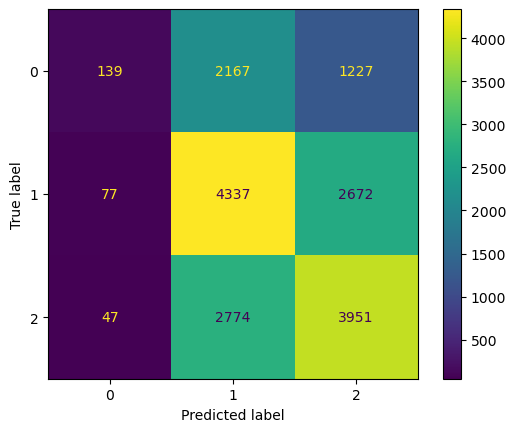

In [71]:
model_evaluation_dict_age['Model_Name'].append('XGBoost_HPT')
evaluate_model(xgb_hpt, X_train_s1, Y_train_s1_age)

#### Evaluating the XGBoost with Grid Search classifier on Test Data Set

Evaluating Testing performance
Accuracy:0.39045671361640083
Precision:0.46184190099006434
Recall:0.4598514936971162
F1Score:0.41591907393849925


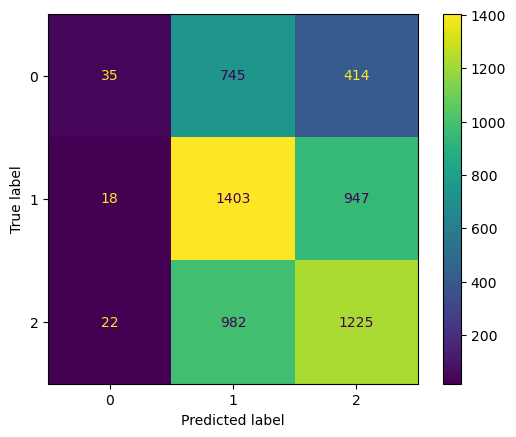

In [72]:
evaluate_model(xgb_hpt, X_test_s1, Y_test_s1_age, False)

### Stacking Classifier Model  for Predicting `Age` for Scenario 1

In [73]:
# 1st set of models
clf1 = LogisticRegression(class_weight = class_weights, random_state=100)
clf2 = RandomForestClassifier(class_weight = class_weights,random_state=100,n_jobs=-1)
xgb_m = xgb.XGBClassifier()

stacking_classifier = StackingCVClassifier(classifiers=[clf1, clf2], meta_classifier=xgb_m, use_probas=True, cv=cross_validation, random_state=100)

In [74]:
#Training Stacking Classifier Model on train data
# Performing Cross Validation on Stacking Classifier

for clf, label in zip([clf1, clf2, stacking_classifier], 
                      ['lr', 
                       'Random Forest', 
                       'StackingClassifier']):

    scores = model_selection.cross_val_score(clf, X_train_s1, Y_train_s1_age, cv=cross_validation, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

Accuracy: 0.42 (+/- 0.00) [lr]
Accuracy: 0.42 (+/- 0.01) [Random Forest]
Accuracy: 0.43 (+/- 0.01) [StackingClassifier]


In [76]:
#Fitting the Stacking Classifier on Training Data
sclf_fit = stacking_classifier.fit(X_train_s1, Y_train_s1_age)

In [77]:
sclf_fit

StackingCVClassifier(classifiers=[LogisticRegression(class_weight={0: 1.64081517124257,
                                                                   1: 0.8180920124188541,
                                                                   2: 0.8560248080330773},
                                                     random_state=100),
                                  RandomForestClassifier(class_weight={0: 1.64081517124257,
                                                                       1: 0.8180920124188541,
                                                                       2: 0.8560248080330773},
                                                         n_jobs=-1,
                                                         random_state=100)],
                     cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                     meta_classifier...
                                                   importance_type=None,
                                                   interaction_constraints=None,
                                                   learning_rate=None,
                                                   max_bin=None,
                                                   max_cat_threshold=None,
                                                   max_cat_to_onehot=None,
                                                   max_delta_step=None,
                                                   max_depth=None,
                                                   max_leaves=None,
                                                   min_child_weight=None,
                                                   missing=nan,
                                                   monotone_constraints=None,
                                                   n_estimators=100,
                                                   n_jobs=None,
                                                   num_parallel_tree=None,
                                                   predictor=None,
                                                   random_state=None, ...),
                     random_state=100, use_probas=True)

In [78]:
# Saving the Stacking Classifier Model as a pickle in a file
path = 'E:\Shobhit\MSDS\Capstone\Y1_Capstone\MLModels\Age Prediction'
filename = f'{path}\\Stacking_Classifier_Age_Scenario1.pkl'
pickle.dump(sclf_fit, open(filename, 'wb'))

In [80]:
# Reading saved Stacking Classifier model
# path = 'E:\\Shobhit\\MSDS\\Capstone\\Y1_Capstone\\MLModels'
# filename = f'{path}\\Stacking_Classifier_Age_Scenario1.pkl'
# sclf_fit = pickle.load(open(filename, 'rb'))
# print(sclf_fit)

#### Evaluating the Stacking Classifier on Training Data Set

Evaluating Training performance
Accuracy:0.37743528930339165
Precision:0.410109006856423
Recall:0.42947501581277675
F1Score:0.4099079449232443


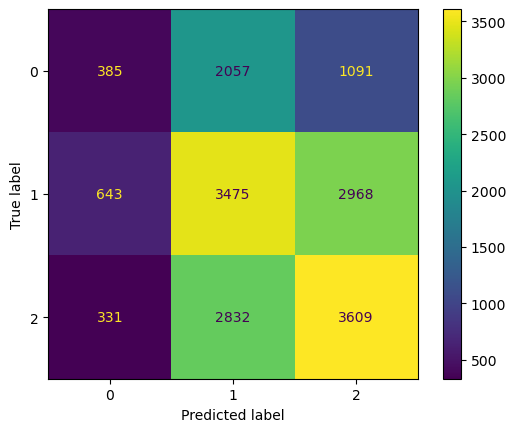

In [81]:
model_evaluation_dict_age['Model_Name'].append('Stacking_Classifier')
evaluate_model(sclf_fit,X_train_s1, Y_train_s1_age)

#### Evaluating the Stacking Classifier Model on Test Data Set

Evaluating Testing performance
Accuracy:0.37677907349902506
Precision:0.41518740139547083
Recall:0.43135900535313415
F1Score:0.4067482305717853


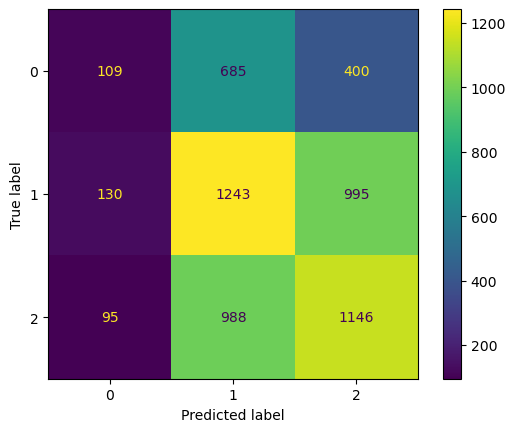

In [82]:
evaluate_model(sclf_fit, X_test_s1, Y_test_s1_age, False)

### Evaluation Metrics

In [91]:
model_evaluation_dict_age

{'Model_Name': ['Logistic_Regression',
  'XGBoost_Basic',
  'XGBoost_HPT',
  'Stacking_Classifier'],
 'Training_Accuracy': [0.4854164531592122,
  0.5289388410532837,
  0.4116090151918795,
  0.37743528930339165],
 'Testing_Accuracy': [0.430699357693958,
  0.3953359442050584,
  0.39045671361640083,
  0.37677907349902506],
 'Precision_Training': [0.4965448389273585,
  0.6134263619909293,
  0.49382038782094567,
  0.410109006856423],
 'Precision_Testing': [0.44077343170206945,
  0.44813701859301436,
  0.46184190099006434,
  0.41518740139547083],
 'Recall_Training': [0.4704157322753148,
  0.5921453625438445,
  0.4845609798171468,
  0.42947501581277675],
 'Recall_Testing': [0.4194439647729235,
  0.45208081505784836,
  0.4598514936971162,
  0.43135900535313415],
 'F1Score_Training': [0.4709104407530134,
  0.5695164706698165,
  0.4412915454958824,
  0.4099079449232443],
 'F1Score_Testing': [0.42054007306029817,
  0.4257636078709659,
  0.41591907393849925,
  0.4067482305717853],
 'Multiclass_log

In [92]:
df_evaluation_age_s1 = pd.DataFrame(model_evaluation_dict_age)

In [93]:
df_evaluation_age_s1

,Model_Name,Training_Accuracy,Testing_Accuracy,Precision_Training,Precision_Testing,Recall_Training,Recall_Testing,F1Score_Training,F1Score_Testing,Multiclass_log_loss_Training,Multiclass_log_loss_Testing
0,Logistic_Regression,0.485416,0.430699,0.496545,0.440773,0.470416,0.419444,0.470910,0.420540,10.843639,11.463224
1,XGBoost_Basic,0.528939,0.395336,0.613426,0.448137,0.592145,0.452081,0.569516,0.425764,0.780504,1.353877
2,XGBoost_HPT,0.411609,0.390457,0.493820,0.461842,0.484561,0.459851,0.441292,0.415919,0.339608,0.369781
3,Stacking_Classifier,0.377435,0.376779,0.410109,0.415187,0.429475,0.431359,0.409908,0.406748,2.591749,1.908549


In [94]:
path = 'E:\Shobhit\MSDS\Capstone\Y1_Capstone\MLModels\Age Prediction'
df_evaluation_age_s1.to_csv(f'{path}\\evaluation_metrics_age_s1.csv',index=False)